# <span style="font-family:Times New Roman">Code 3. Набор 3</span> 

Импортируем необходимые библиотеки

In [49]:
import pandas as pd
import numpy as np
import pickle
import time
import json

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout

from get_features import get_song_features_set_1

Импортируем стиль визуализации из файла `custom_mplstyle.txt`

In [2]:
plt.style.use('ExtraData\\custom_mplstyle.txt')

In [41]:
%%javascript
IPython.notebook.kernel.execute('file_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

Импортируем необходимые списки

In [4]:
with open('genre_names.txt', 'r') as f:
    genre_names = f.read().split(';')

In [5]:
with open('genre_names_rus.txt', 'r') as f:
    genre_names_rus = f.read().split(';')

In [6]:
with open('genre_codes.pkl', 'rb') as f:
    genre_codes = pickle.load(f)

## <span style="font-family:Times New Roman">Описание набора данных:</span> 
#### 5 параметров, 10 делений, 10 000 аудио по 3 секунды, shape = (10 000, 125, 5)</span> 
аудиофайл разделяется на 10 отрывков \
$\rightarrow$в каждом  125 списков \
$\rightarrow$в каждом 5 значений MFCC


|  №  |    Параметр   |
|-----|---------------|
|**1**|mfcc$_1$|
|**2**|mfcc$_2$|
|**3**|mfcc$_3$|
|**4**|mfcc$_4$|
|**5**|mfcc$_5$|


## <span style="font-family:Times New Roman">Используемые функции:</span> 

**1\.** `confusion_martix_plot` – график матрицы ошибок

Визуализируем матрицу ошибок, которая показывает производительность модели

In [7]:
def confusion_martix_plot(test, pred, acc, model_type, save=True):
    cm = confusion_matrix(test, pred)

    fig, axes = plt.subplots(1, 1, figsize=(10,7))
    fig.patch.set_facecolor('#371d49')
    
    sns.heatmap(cm,
                linewidths=.5,
                linecolor="black",
                cmap=plt.cm.RdPu_r,
                annot=True, 
                fmt='g',
                annot_kws={'fontsize':18},
                xticklabels=genre_names,
                yticklabels=genre_names)
    
    plt.title(f'Accuracy = {acc:.2f}', fontsize=22, y=1.05)
    plt.xlabel('Predicted', fontsize=18)
    plt.ylabel('Real', fontsize=18)
    
    fn = file_name.split('.')[0].replace(' ', '_').lower()
    lt = '_'.join(str(x) for x in list(time.localtime())[1:-3])
    if save:
        plt.savefig(f'Images/cm_{fn}_{model_type}_{lt}.png', facecolor='#371d49', bbox_inches = 'tight', dpi = 300)
    plt.show()

**2\.** `plot_performance` – график обучения модели

Визуализируем изменение `accuracy` и `loss` значений в процессе обучения модели

In [8]:
def performance_plot(hist, save=False):

    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(len(acc))
    
    fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
    
    line_1 = axes[0].plot(epochs, acc, '#18c0c4', label='Training accuracy')
    line_2 = axes[0].plot(epochs, val_acc, '#fefeff', label='Validation accuracy')
    axes[0].set_title('Training and validation accuracy')

    line_3 = axes[1].plot(epochs, loss, '#A267F5', label='Training Loss')
    line_4 = axes[1].plot(epochs, val_loss, '#f62196', label='Validation Loss')
    axes[1].set_title('Training and validation loss')

    lines = line_1 + line_2 + line_3 + line_4
    labs = [l.get_label() for l in lines]
    plt.legend(lines, labs, loc='center', bbox_to_anchor=(1.2, 0.5))
    lt = '_'.join(str(x) for x in list(time.localtime())[1:-3])
    if save:
        plt.savefig(f'Images/performance_{lt}.png', facecolor='#371d49', bbox_inches = 'tight', dpi = 300)
    plt.show()

**3\.** `prepare_datasets` – предобработка данных

С помощью `sklearn.model_selection.train_test_split` разделяем данные в два этапа: на `train` – `validation` выборки и на `train` – `test` выборки. Также, приводим данные в трёхмерную форму:

In [9]:
def prepare_datasets(X, Y, split_size):
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=split_size, random_state=10)
    X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=split_size, random_state=10)
    
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

**4\.** `load_data` – загрузка данных из набора №3

Считываем данные с помощью `json.load`, определяем `X` и `Y`

In [10]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    X = np.array(data["features"])
    Y = np.array(data["labels"])

    return X, Y

## <span style="font-family:Times New Roman">Импорт данных</span> 
Загружаем данные из файла `features_set_3.csv` с помощью функции `load_data`, получаем на выходе функции разделенный на `X` и `Y`:

Разделяем датасет на `X` и `Y`

In [11]:
features_set_3_path = 'C:\\Users\\micha\\OneDrive\\Рабочий стол\\Курсовая\\features_set_3.json'
X, Y = load_data(features_set_3_path)

In [12]:
X.shape

(10000, 125, 5)

С помощью функции `prepare_datasets` разделяем данные на обучающую, валидационную и тестовую выборки:

Получение `train`, `validation` и `test` выборок

In [13]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_datasets(X, Y, 0.2)
input_shape = X_train.shape[1:]
input_shape

(125, 5, 1)

## <span style="font-family:Times New Roman">1\. CNN (Convolutional Neural Network)</span> 
Функция `CNN_model` содержит архитектуру CNN-модели:

In [159]:
def predict_genre_test(path):
    features = {"labels": [], "features": []}
    num_slices = 10
    duration = 29

    y, sr = librosa.load(path, duration=duration)
    samples_per_slice = int(duration * sr / num_slices)
    for s in range(num_slices):
        start_sample = samples_per_slice * s
        end_sample = start_sample + samples_per_slice
        mfcc = librosa.feature.mfcc(y=y[start_sample:end_sample], sr=sr, n_mfcc=5)
        mfcc = mfcc.T
        features["features"].append(mfcc)
   
    return features['features'][0].reshape(1,125, 5, 1)

In [41]:
def CNN_model(input_shape):

    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,1), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(48, (3,1), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(48, (3,1), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, (3,1), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.L1(l=0.01))
    ])

    return model

### <span style="font-family:Times New Roman">Компилируем и обучаем модель</span> 
* Оптимизатор: **RMSprop**, learning rate = $1e-3$
* Функция потерь (Loss function): **SparseCategoricalCrossentropy**  – для двух и более классов целовчисленных меток
* Количество эпох: **30**
* Размер батча: **32**
* Для каждой эпохи рассчитывается `loss`, `accuracy` для обучающей и валидационных выборок 

Epoch 1/30
200/200 [==============================] - 3s 11ms/step - loss: 2.5033 - acc: 0.4095 - val_loss: 2.0985 - val_acc: 0.4785
Epoch 2/30
200/200 [==============================] - 2s 10ms/step - loss: 1.9409 - acc: 0.5084 - val_loss: 1.8457 - val_acc: 0.5130
Epoch 3/30
200/200 [==============================] - 2s 11ms/step - loss: 1.6345 - acc: 0.5667 - val_loss: 1.6294 - val_acc: 0.5375
Epoch 4/30
200/200 [==============================] - 2s 10ms/step - loss: 1.4438 - acc: 0.6017 - val_loss: 1.3490 - val_acc: 0.6380
Epoch 5/30
200/200 [==============================] - 2s 10ms/step - loss: 1.3068 - acc: 0.6333 - val_loss: 1.3134 - val_acc: 0.6200
Epoch 6/30
200/200 [==============================] - 2s 10ms/step - loss: 1.1968 - acc: 0.6608 - val_loss: 1.3774 - val_acc: 0.5940
Epoch 7/30
200/200 [==============================] - 2s 10ms/step - loss: 1.1207 - acc: 0.6823 - val_loss: 1.2388 - val_acc: 0.6375
Epoch 8/30
200/200 [==============================] - 2s 10ms/step - 

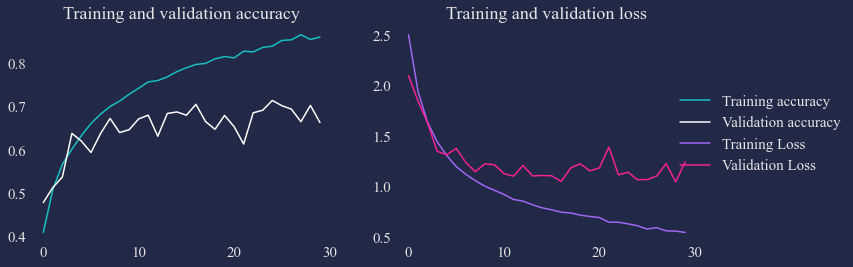

In [39]:
model = CNN_model(input_shape)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                    epochs=30, batch_size=32)

performance_plot(history)

Проверяем модель на тестовой выборке, строим матрицу ошибок и выводим показатели метрик

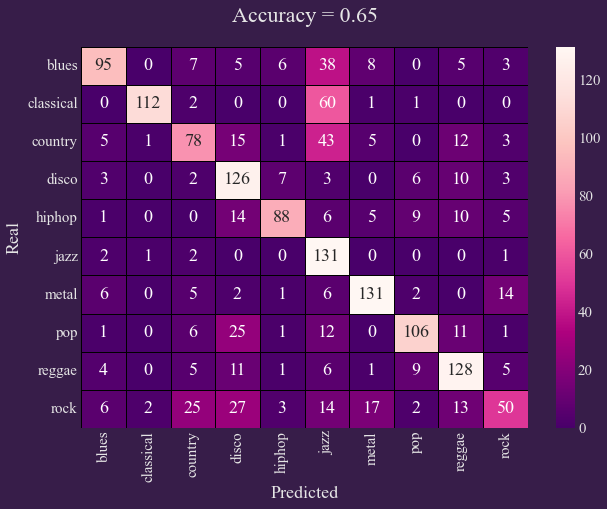

Показатели метрик
 accuracy:	 0.6531
       f1:	 0.6536
   recall:	 0.6531
precision:	 0.7003


In [40]:
prediction = model.predict(X_test, verbose=0)
Y_pred = np.argmax(prediction, axis=1)

metrics = {' accuracy' : accuracy_score(Y_test, Y_pred), 
           '       f1' : f1_score(Y_test, Y_pred, average='weighted'), 
           '   recall' : recall_score(Y_test, Y_pred, average='weighted'), 
           'precision' : precision_score(Y_test, Y_pred, average='weighted')}

confusion_martix_plot(Y_test, Y_pred, acc=metrics[' accuracy'], model_type='CNN', save=False)

print('Показатели метрик')
for metric, value in metrics.items():
    print(f'{metric}:\t \033[1m{value:.4f}\033[0m') 

Выводим сводную информацию о нейронной сети:

In [45]:
model.summary(line_length=90)

Model: "sequential_11"
__________________________________________________________________________________________
 Layer (type)                           Output Shape                        Param #       
 conv2d_43 (Conv2D)                     (None, 123, 5, 32)                  128           
                                                                                          
 max_pooling2d_43 (MaxPooling2D)        (None, 62, 3, 32)                   0             
                                                                                          
 batch_normalization_43 (BatchNormaliza  (None, 62, 3, 32)                  128           
 tion)                                                                                    
                                                                                          
 conv2d_44 (Conv2D)                     (None, 60, 3, 48)                   4656          
                                                                   

## <span style="font-family:Times New Roman">2\. RNN (Recurrent Neural Network)</span> 
Функция `RNN_model` содержит архитектуру RNN-модели:

In [63]:
def RNN_model(input_shape):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((input_shape[0], input_shape[1]), input_shape=input_shape),
        tf.keras.layers.LSTM(64, input_shape= input_shape, return_sequences=True),
        tf.keras.layers.LSTM(64),
        
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(10, activation='softmax')
    ])

    return model

### <span style="font-family:Times New Roman">Компилируем и обучаем модель</span> 
* Оптимизатор: **adam**
* Функция потерь (Loss function): **SparseCategoricalCrossentropy**  – для двух и более классов целовчисленных меток
* Количество эпох: **20**
* Размер батча: **32**
* Для каждой эпохи рассчитывается `loss`, `accuracy` для обучающей и валидационных выборок 

Epoch 1/20
200/200 [==============================] - 12s 49ms/step - loss: 1.8633 - acc: 0.3403 - val_loss: 1.5805 - val_acc: 0.4385
Epoch 2/20
200/200 [==============================] - 9s 47ms/step - loss: 1.5794 - acc: 0.4339 - val_loss: 1.4781 - val_acc: 0.4725
Epoch 3/20
200/200 [==============================] - 9s 45ms/step - loss: 1.4718 - acc: 0.4780 - val_loss: 1.4217 - val_acc: 0.4900
Epoch 4/20
200/200 [==============================] - 9s 45ms/step - loss: 1.4242 - acc: 0.4969 - val_loss: 1.3835 - val_acc: 0.5090
Epoch 5/20
200/200 [==============================] - 9s 45ms/step - loss: 1.3720 - acc: 0.5125 - val_loss: 1.3305 - val_acc: 0.5095
Epoch 6/20
200/200 [==============================] - 9s 46ms/step - loss: 1.3137 - acc: 0.5403 - val_loss: 1.2872 - val_acc: 0.5410
Epoch 7/20
200/200 [==============================] - 9s 46ms/step - loss: 1.2898 - acc: 0.5444 - val_loss: 1.3149 - val_acc: 0.5340
Epoch 8/20
200/200 [==============================] - 9s 46ms/step -

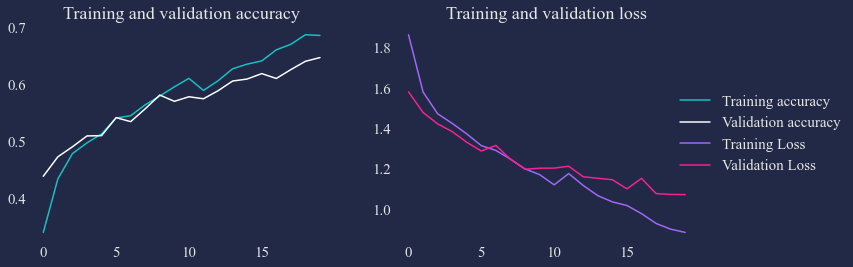

In [64]:
model = RNN_model(input_shape)

model.compile(optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                    epochs=20, batch_size=32)

performance_plot(history)

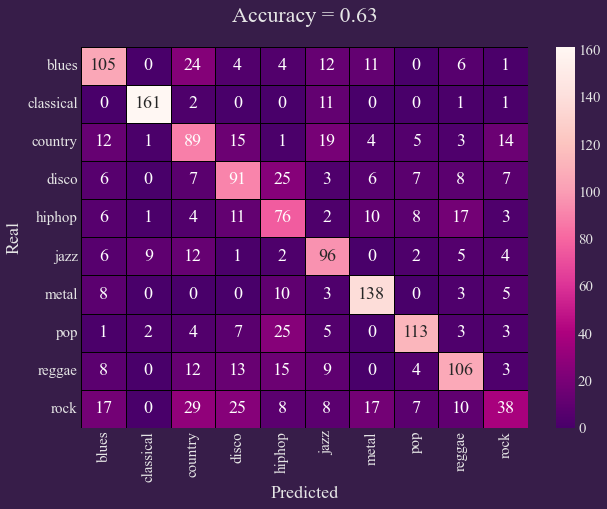

Показатели метрик
 accuracy:	 0.6331
       f1:	 0.6272
   recall:	 0.6331
precision:	 0.6327


In [66]:
prediction = model.predict(X_test, verbose=0)
Y_pred = np.argmax(prediction, axis=1)

metrics = {' accuracy' : accuracy_score(Y_test, Y_pred), 
           '       f1' : f1_score(Y_test, Y_pred, average='weighted'), 
           '   recall' : recall_score(Y_test, Y_pred, average='weighted'), 
           'precision' : precision_score(Y_test, Y_pred, average='weighted')}

confusion_martix_plot(Y_test, Y_pred, acc=metrics[' accuracy'], model_type='RNN', save=False)

print('Показатели метрик')
for metric, value in metrics.items():
    print(f'{metric}:\t \033[1m{value:.4f}\033[0m') 

Выводим сводную информацию о нейронной сети:

In [67]:
model.summary(line_length=90)

Model: "sequential_22"
__________________________________________________________________________________________
 Layer (type)                           Output Shape                        Param #       
 reshape_8 (Reshape)                    (None, 125, 5)                      0             
                                                                                          
 lstm_12 (LSTM)                         (None, 125, 64)                     17920         
                                                                                          
 lstm_13 (LSTM)                         (None, 64)                          33024         
                                                                                          
 dense_36 (Dense)                       (None, 64)                          4160          
                                                                                          
 dropout_22 (Dropout)                   (None, 64)                 